In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


from scipy.stats import chi2_contingency, mannwhitneyu

import pickle

In [ ]:
data_path = "/content/diabetes_risk.csv"
data = pd.read_csv(data_path)
data.head().T

|index|0|1|2|3|4|
|---|---|---|---|---|---|
|Age|40|58|41|45|60|
|Gender|Male|Male|Male|Male|Male|
|Polyuria|No|No|Yes|No|Yes|
|Polydipsia|Yes|No|No|No|Yes|
|sudden weight loss|No|No|No|Yes|Yes|
|weakness|Yes|Yes|Yes|Yes|Yes|
|Polyphagia|No|No|Yes|Yes|Yes|
|Genital thrush|No|No|No|Yes|No|
|visual blurring|No|Yes|No|No|Yes|
|Itching|Yes|No|Yes|Yes|Yes|
|Irritability|No|No|No|No|Yes|
|delayed healing|Yes|No|Yes|Yes|Yes|
|partial paresis|No|Yes|No|No|Yes|
|muscle stiffness|Yes|No|Yes|No|Yes|
|Alopecia|Yes|Yes|Yes|No|Yes|
|Obesity|Yes|No|No|No|Yes|
|class|Positive|Positive|Positive|Positive|Positive|

In [ ]:
#  0   Age                 518 non-null    float64
#  1   Gender              520 non-null    object
#  2   Polyuria            520 non-null    object
#  3   Polydipsia          520 non-null    object
#  4   sudden weight loss  520 non-null    object
#  5   weakness            520 non-null    object
#  6   Polyphagia          520 non-null    object
#  7   Genital thrush      520 non-null    object
#  8   visual blurring     519 non-null    object
#  9   Itching             520 non-null    object
#  10  Irritability        519 non-null    object
#  11  delayed healing     520 non-null    object
#  12  partial paresis     520 non-null    object
#  13  muscle stiffness    520 non-null    object
#  14  Alopecia            520 non-null    object
#  15  Obesity             520 non-null    object
#  16  class               519 non-null    object

In [12]:
data_columns = list(data.columns)
cat_columns = data.select_dtypes("object").columns
numeric_columns = data.select_dtypes(exclude="object").columns

In [22]:
data["Age"].fillna(np.mean(data["Age"]), inplace=True)
data["visual blurring"].fillna(data["visual blurring"].mode()[0], inplace=True)
data["Irritability"].fillna(data["Irritability"].mode()[0], inplace=True)

data.dropna(inplace=True)

In [ ]:
#  0   Age                 519 non-null    float64
#  1   Gender              519 non-null    object
#  2   Polyuria            519 non-null    object
#  3   Polydipsia          519 non-null    object
#  4   sudden weight loss  519 non-null    object
#  5   weakness            519 non-null    object
#  6   Polyphagia          519 non-null    object
#  7   Genital thrush      519 non-null    object
#  8   visual blurring     519 non-null    object
#  9   Itching             519 non-null    object
#  10  Irritability        519 non-null    object
#  11  delayed healing     519 non-null    object
#  12  partial paresis     519 non-null    object
#  13  muscle stiffness    519 non-null    object
#  14  Alopecia            519 non-null    object
#  15  Obesity             519 non-null    object
#  16  class               519 non-null    object

In [11]:
for col in cat_columns:
    print(col)
    print(data[col].value_counts())
    print("*"*50)

Gender
Male      328
Female    192
Name: Gender, dtype: int64
**************************************************
Polyuria
No     262
Yes    258
Name: Polyuria, dtype: int64
**************************************************
Polydipsia
No     287
Yes    233
Name: Polydipsia, dtype: int64
**************************************************
sudden weight loss
No      302
Yes     216
Yes&      1
          1
Name: sudden weight loss, dtype: int64
**************************************************
weakness
Yes    305
No     215
Name: weakness, dtype: int64
**************************************************
Polyphagia
No     283
Yes    237
Name: Polyphagia, dtype: int64
**************************************************
Genital thrush
No     404
Yes    116
Name: Genital thrush, dtype: int64
**************************************************
visual blurring
No     287
Yes    232
Name: visual blurring, dtype: int64
**************************************************
Itching
No     267
Yes    253


In [30]:
data = data[data["sudden weight loss"].isin(["Yes", "No"])]

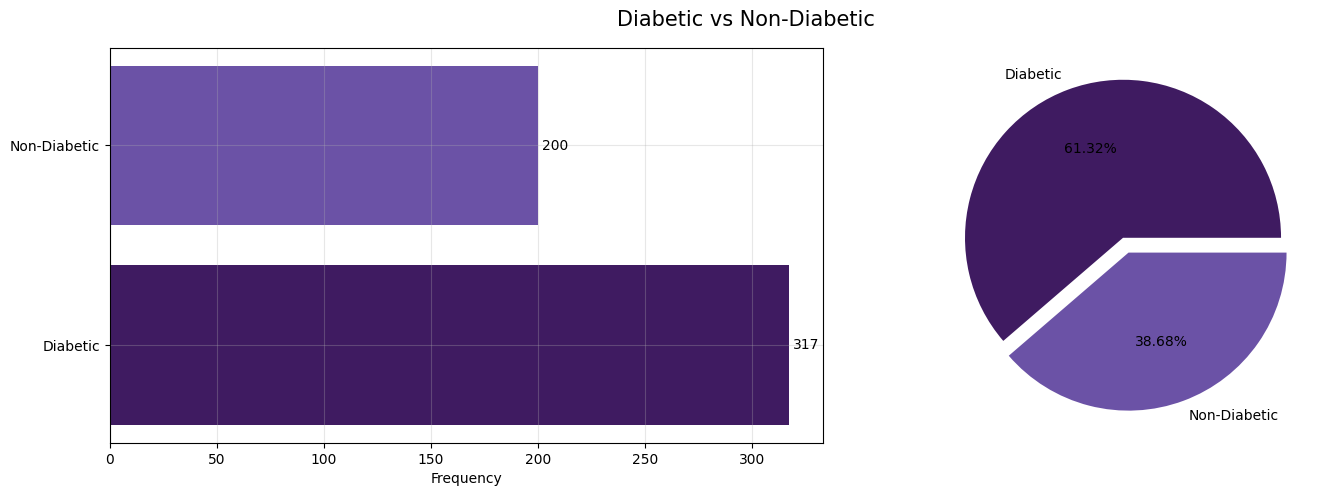

In [32]:
data_to_plot = data["class"].value_counts()
iraqidata_c = ['#6B52A6','#3F1B61'][::-1]

fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].barh(y=data_to_plot.index, width=data_to_plot.values, color=iraqidata_c)
ax[0].set_xlabel("Frequency")
ax[0].set_yticks(["Negative", "Positive"], ["Non-Diabetic", "Diabetic"])
ax[0].grid(alpha=0.3)


for index, values in enumerate(data_to_plot):
    ax[0].text(values+2, index, str(values), va="center")

ax[1].pie(data_to_plot, labels=["Diabetic", "Non-Diabetic"], colors=iraqidata_c, explode=[0.05, 0.05], autopct="%.2f%%")

fig.suptitle("Diabetic vs Non-Diabetic", fontsize=15)
plt.tight_layout(pad=1)
plt.show()

In [33]:
significant_columns = []

for column in cat_columns:

    contingency_table = pd.crosstab(data[column], data['class'])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    if p_value < 0.05:significant_columns.append(column)

print("Significant columns:", significant_columns)

Significant columns: ['Gender', 'Polyuria', 'Polydipsia', 'sudden weight loss', 'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring', 'Irritability', 'partial paresis', 'muscle stiffness', 'Alopecia', 'class']


In [35]:
u_stat, p_value_age = mannwhitneyu(data[data['class'] == "Negative"]['Age'], data[data['class'] == "Positive"]['Age'])

if p_value_age < 0.05:
    print("توجد فروق ذات دلالة إحصائية")
    significant_columns.append("Age")

توجد فروق ذات دلالة إحصائية


In [ ]:
data = data[significant_columns]
data.head().T

|index|0|1|2|3|4|
|---|---|---|---|---|---|
|Gender|Male|Male|Male|Male|Male|
|Polyuria|No|No|Yes|No|Yes|
|Polydipsia|Yes|No|No|No|Yes|
|sudden weight loss|No|No|No|Yes|Yes|
|weakness|Yes|Yes|Yes|Yes|Yes|
|Polyphagia|No|No|Yes|Yes|Yes|
|Genital thrush|No|No|No|Yes|No|
|visual blurring|No|Yes|No|No|Yes|
|Irritability|No|No|No|No|Yes|
|partial paresis|No|Yes|No|No|Yes|
|muscle stiffness|Yes|No|Yes|No|Yes|
|Alopecia|Yes|Yes|Yes|No|Yes|
|class|Positive|Positive|Positive|Positive|Positive|
|Age|40|58|41|45|60|

In [38]:
lb = LabelEncoder()
data["class"] = lb.fit_transform(data["class"])

In [39]:
data_columns = list(data.columns)
cat_columns = data.select_dtypes("object").columns
numeric_columns = data.select_dtypes(exclude="object").columns

In [40]:
X = data.drop("class", axis=1)
y = data["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [41]:
preprocessor = ColumnTransformer(
    [("cat", OneHotEncoder(drop="first"), cat_columns)],
    remainder='passthrough'
)

pipeline = Pipeline(
    [
        ("cats", preprocessor),
        ("scaler", MinMaxScaler())
    ]
)

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [43]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

print(knn.score(X_train, y_train), knn.score(X_test, y_test))

0.9588377723970944 0.9326923076923077


In [44]:
param_grid = {'n_neighbors': [1,3,5,7,9]}

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

best_knn = grid_search.best_estimator_

y_pred = best_knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Set: {accuracy}")

Best Hyperparameters: {'n_neighbors': 1}
Accuracy on Test Set: 0.9807692307692307


In [45]:


# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Logistic Regression Accuracy: {accuracy_logreg}")

# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {accuracy_dt}")

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf}")

# Support Vector Machine (SVM)
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm}")

Logistic Regression Accuracy: 0.9230769230769231
Decision Tree Accuracy: 0.9134615384615384
Random Forest Accuracy: 0.9903846153846154
SVM Accuracy: 0.9903846153846154


In [48]:
with open('rf_model.pkl', 'wb') as file_:
    pickle.dump(rf, file_)

with open('svm_model.pkl', 'wb') as file_:
    pickle.dump(svm, file_)

In [87]:
with open("rf_model.pkl", "rb") as our_model:
    our_model = pickle.load(our_model)
    for i in range(4):
        random_sample = random.randint(1, 104)
        print(f"Actual: {y_test.reset_index().drop('index', axis=1).iloc[random_sample][0]}")
        print(f"Predicted: {our_model.predict(X_test[random_sample].reshape(1, -1))[0]}")
        print("-"*10)

Actual: 0
Predicted: 0
----------
Actual: 1
Predicted: 1
----------
Actual: 1
Predicted: 1
----------
Actual: 1
Predicted: 1
----------
